In [1]:
import tensorflow as tf
print("Versión de tensorflow:{}".format(tf.__version__))
print("GPU:{}".format(tf.test.gpu_device_name()))

Versión de tensorflow:2.3.0
GPU:/device:GPU:0


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
#from tensorflow.keras.applications import ResNet50V2
#from tensorflow import keras
#from tensorflow.keras import layers

In [4]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [5]:
import os 
os.listdir('.')

['.ipynb_checkpoints',
 '867855885.jpg',
 'cassava-disease',
 'Cassava_best_modelP8.h5',
 'Cassava_best_modelP9.h5',
 'Cassava_best_modelPX.h5',
 'CLASIFICA BIEN',
 'CONFUNDIDAS',
 'FineTuningP8.ipynb',
 'FineTuningP9.ipynb',
 'FineTuningPX.ipynb',
 'foo.png',
 'healthy',
 'healthy con las colombianas',
 'Sanas descartadas',
 'test 2',
 'test 3',
 'Untitled.ipynb']

In [6]:
# Verificación de lo que hay en la carpeta Kaggle
PATH = 'cassava-disease'

os.listdir(PATH)

['Confundidas por el modelo',
 'test',
 'test 2',
 'test 3',
 'trainCompletaMod3',
 'trainCompletaMod4',
 'trainCompletaMod5.1',
 'Validacion1',
 'Validacion2']

In [7]:
base_dir = os.path.join(os.path.dirname(PATH), 'cassava-disease')
train_dir = os.path.join(base_dir, 'trainCompletaMod5.1')
test_dir = os.path.join(base_dir, 'test 2')

train_cbb_dir = os.path.join(train_dir, 'cbb')  # directory with our training cat pictures
train_cbsd_dir = os.path.join(train_dir, 'cbsd')  # directory with our training dog pictures
train_cgm_dir = os.path.join(train_dir, 'cgm')  # directory with our training dog pictures
train_cmd_dir = os.path.join(train_dir, 'cmd')  # directory with our training dog pictures
train_healthy_dir = os.path.join(train_dir, 'healthy')  # directory with our training dog pictures
#validation_0_dir = os.path.join(validation_dir, '0')  # directory with our validation cat pictures

In [8]:
num_cbb_tr = len(os.listdir(train_cbb_dir))
num_cbsd_tr = len(os.listdir(train_cbsd_dir))
num_cgm_tr = len(os.listdir(train_cgm_dir))
num_cmd_tr = len(os.listdir(train_cmd_dir))
num_healthy_tr = len(os.listdir(train_healthy_dir))

#num_0_val = len(os.listdir(validation_0_dir))

total_train = num_cbb_tr + num_cbsd_tr + num_cgm_tr + num_cmd_tr + num_healthy_tr
#total_val = num_0_val 

In [10]:
print('total training cbb images:', num_cbb_tr)
print('total training cbsd images:', num_cbsd_tr)
print('total training cgm images:', num_cgm_tr)
print('total training cmd images:', num_cmd_tr)
print('total training healthy images:', num_healthy_tr)

#print('total validation 0 images:', num_0_val)
print("--")
print("Total training images:", total_train)
#print("Total validation images:", total_val)

total training cbb images: 1224
total training cbsd images: 1224
total training cgm images: 1224
total training cmd images: 1224
total training healthy images: 1224
--
Total training images: 6120


In [11]:
BATCH_SIZE = 8  # Number of training examples to process before updating our models variables
IMG_SHAPE  = 512  # Our training data consists of images with width of 150 pixels and height of 150 pixels

In [12]:
train_image_generator      = ImageDataGenerator(rescale=1./255,
                                               validation_split=0.1022,
                                               rotation_range = 45,
                                               zoom_range = 0.2,
                                               vertical_flip=True,
                                               horizontal_flip=True,
                                               fill_mode = 'nearest',
                                               shear_range = 0.1,
                                               height_shift_range = 0.1,
                                               width_shift_range = 0.1)  # Generator for our training data
#validation_image_generator = ImageDataGenerator(rescale=1./255)  # Generator for our validation data

In [13]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,                                                    
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                           class_mode='sparse',
                                                           subset='training')

Found 5495 images belonging to 5 classes.


In [14]:
NUM_TRAINING_IMAGES=5495

In [15]:
val_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=train_dir,                                                              
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                              class_mode='sparse',
                                                              subset='validation')

Found 625 images belonging to 5 classes.


In [16]:
NUM_VALIDATION_IMAGES=625

In [18]:
sample_training_images, _ = next(train_data_gen) 

In [19]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

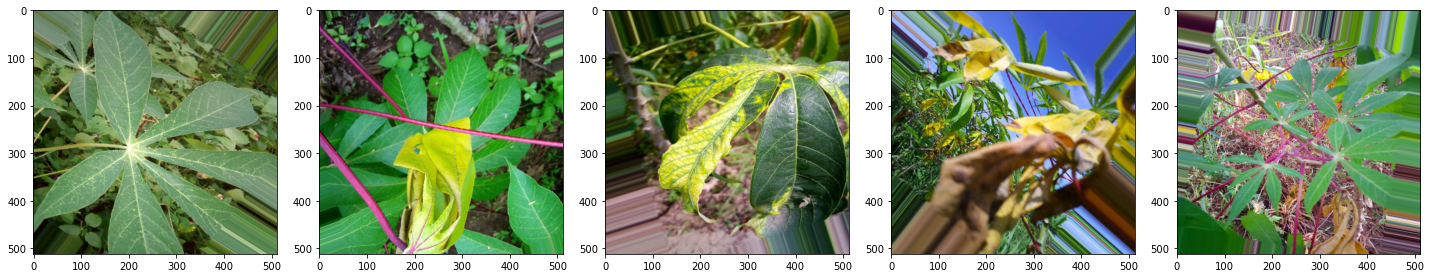

In [20]:
plotImages(sample_training_images[:5])  # Plot images 0-4

In [21]:
model1 = tf.keras.applications.Xception(weights='imagenet')

In [22]:
model1.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [23]:
def create_model():
    base_model = tf.keras.applications.Xception(input_shape=(IMG_SHAPE,IMG_SHAPE, 3),
                                                include_top=False,
                                                weights='imagenet')
    
    base_model.trainable = True
    
    set_trainable = False
    
    for layer in base_model.layers:
        if layer.name == 'block13_sepconv1_act':
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False
   
 
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Flatten(),
        #tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1024, activation='relu',kernel_regularizer=tf.keras.regularizers.L2(l2=0.01)),
        tf.keras.layers.Dense(512, activation="relu",kernel_regularizer=tf.keras.regularizers.L2(l2=0.01)),
        #tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(5, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=["acc"])
    
    return model

In [24]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 16, 16, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 2565      
Total params: 23,487,021
Trainable params: 9,413,925
Non-trainable params: 14,073,096
____________________________________

In [25]:
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
VALID_STEPS = NUM_VALIDATION_IMAGES // BATCH_SIZE

In [26]:
# Save the model with the minimum validation loss
checkpoint_cb = ModelCheckpoint("Cassava_best_modelPX.h5",
                                    save_best_only=True,
                                    monitor = 'val_loss',
                                    mode='min')
#early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                           #patience = 5, mode = 'min', verbose = 1,
                           #restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, 
                              patience = 2, min_delta = 0.001, 
                              mode = 'min', verbose = 1)

In [27]:
EPOCHS = 35
history = model.fit(
    train_data_gen, epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=val_data_gen,
    validation_steps=VALID_STEPS,
    callbacks = [checkpoint_cb, reduce_lr])#class_weight=class_weight2

Epoch 1/35
686/686 [==============================] - 503s 733ms/step - loss: 1.7714 - acc: 0.5056 - val_loss: 1.2267 - val_acc: 0.5593
Epoch 2/35
686/686 [==============================] - 384s 560ms/step - loss: 0.8380 - acc: 0.7294 - val_loss: 0.5959 - val_acc: 0.8478
Epoch 3/35
686/686 [==============================] - 379s 553ms/step - loss: 0.6467 - acc: 0.8086 - val_loss: 0.7061 - val_acc: 0.7949
Epoch 4/35
686/686 [==============================] - 385s 562ms/step - loss: 0.5518 - acc: 0.8382 - val_loss: 0.4496 - val_acc: 0.8718
Epoch 5/35
686/686 [==============================] - 393s 573ms/step - loss: 0.4953 - acc: 0.8593 - val_loss: 0.3370 - val_acc: 0.9071
Epoch 6/35
686/686 [==============================] - 386s 563ms/step - loss: 0.4509 - acc: 0.8693 - val_loss: 0.4075 - val_acc: 0.9022
Epoch 7/35
686/686 [==============================] - ETA: 0s - loss: 0.4149 - acc: 0.8830
Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
686/686 [====

In [17]:
from tensorflow import keras
final_model = keras.models.load_model('Cassava_best_modelPX.h5')

## Gráfico de aprendizaje

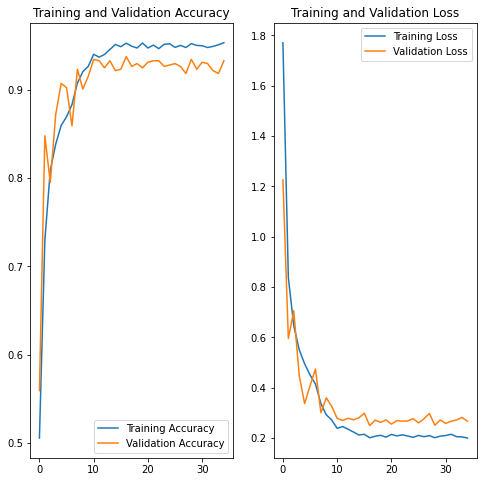

In [29]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(35)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo.png')
plt.show()

In [30]:
test_image_generator = ImageDataGenerator(rescale = 1./255)

In [31]:
import random
seed = random.randint(1, 1000)
test_data_gen = test_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=test_dir,                                                    
                                                           shuffle=False,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                           class_mode='sparse')                                                           

Found 625 images belonging to 5 classes.


In [32]:
NUM_TEST_IMAGES = 625
TEST_STEPS = NUM_TEST_IMAGES // BATCH_SIZE

In [33]:
# Evaluate the performance of the model
from tensorflow.keras.models import Model, load_model
model.load_weights("Cassava_best_modelPX.h5")
evaluate = model.evaluate(test_data_gen, steps = TEST_STEPS, verbose =1)

print('Accuracy Test : {}'.format(evaluate[1]))

78/78 [==============================] - 30s 381ms/step - loss: 0.2095 - acc: 0.9455
Accuracy Test : 0.9455128312110901


## Matriz de confusión y otras métricas

              precision    recall  f1-score   support

           0     0.9746    0.9200    0.9465       125
           1     0.9669    0.9360    0.9512       125
           2     0.9516    0.9440    0.9478       125
           3     0.9453    0.9680    0.9565       125
           4     0.8955    0.9600    0.9266       125

    accuracy                         0.9456       625
   macro avg     0.9468    0.9456    0.9457       625
weighted avg     0.9468    0.9456    0.9457       625



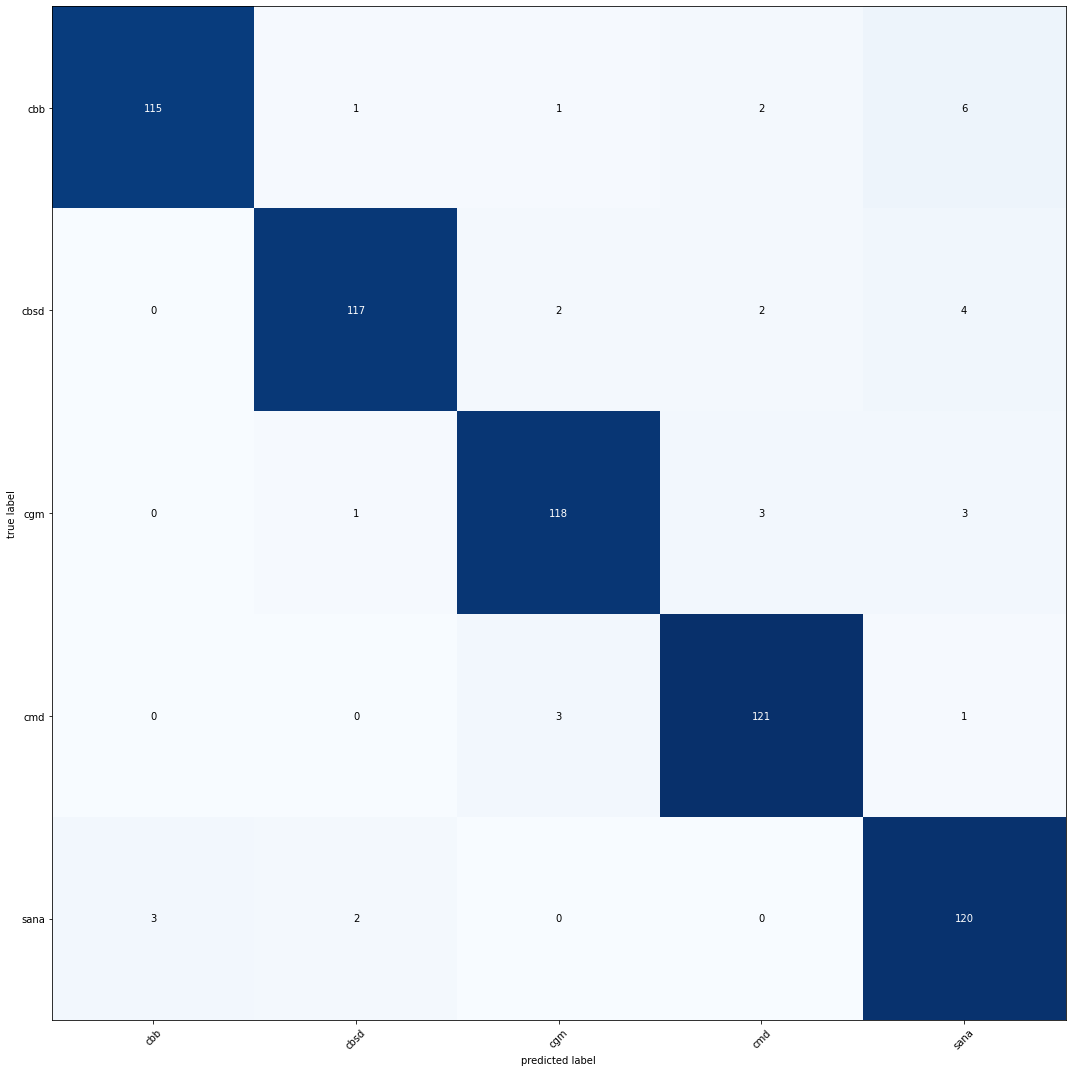

In [34]:
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

names = ['cbb','cbsd','cgm','cmd','sana']

custom_Model= keras.models.load_model('Cassava_best_modelPX.h5')
#modelt = custom_model

predictions = custom_Model.predict_generator(generator=test_data_gen)

y_pred = np.argmax(predictions, axis=1)
y_real = test_data_gen.classes


matc=confusion_matrix(y_real, y_pred)

plot_confusion_matrix(conf_mat=matc, figsize=(15,15), class_names = names, show_normed=False)
plt.tight_layout()
print(metrics.classification_report(y_real,y_pred, digits = 4))

## Código confiable para Predicciones

In [94]:
#val_data_dir = 'C:/Users/bendf/Documents/Prueba/'  
#test_images = os.listdir(val_data_dir)
IMG_SHAPE=512
validation_dir = os.path.join(base_dir, 'Validacion2')
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(batch_size=20,
                                                directory= validation_dir,
                                                target_size=(IMG_SHAPE, IMG_SHAPE), 
                                                class_mode='categorical', 
                                                shuffle=True)

Found 1 images belonging to 1 classes.


In [95]:
val_images=next(val_generator)[0]
val_images

array([[[[0.54509807, 0.29411766, 0.43921572],
         [0.6784314 , 0.41960788, 0.56078434],
         [0.7137255 , 0.45882356, 0.5921569 ],
         ...,
         [0.32156864, 0.09019608, 0.20000002],
         [0.31764707, 0.09019608, 0.18823531],
         [0.7137255 , 0.72156864, 0.7176471 ]],

        [[0.83921576, 0.5803922 , 0.7294118 ],
         [0.8117648 , 0.5529412 , 0.69411767],
         [0.7568628 , 0.49411768, 0.6313726 ],
         ...,
         [0.3137255 , 0.09411766, 0.20000002],
         [0.32156864, 0.09411766, 0.19215688],
         [0.7137255 , 0.72156864, 0.7176471 ]],

        [[0.69803923, 0.43137258, 0.5764706 ],
         [0.627451  , 0.3647059 , 0.5019608 ],
         [0.58431375, 0.30980393, 0.4431373 ],
         ...,
         [0.33333334, 0.1137255 , 0.21176472],
         [0.37254903, 0.15294118, 0.2509804 ],
         [0.7137255 , 0.72156864, 0.7176471 ]],

        ...,

        [[0.10980393, 0.00784314, 0.04313726],
         [0.10588236, 0.00392157, 0.03921569]

In [96]:
classes = final_model.predict(val_images)  #y_pred
y_pred = np.argmax(classes, axis=1)
classes

array([[1.4338109e-03, 1.7396502e-01, 3.1700884e-03, 8.2098049e-01,
        4.5060040e-04]], dtype=float32)

In [97]:
import skimage

IndexError: index 1 is out of bounds for axis 0 with size 1

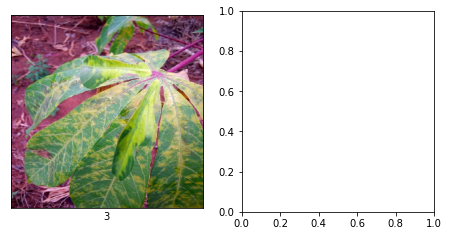

In [98]:
# Mostramos las 20 imágenes del batch y las etiquetas asignadas por MobileNet.
plot_n_images = 10
fig = plt.figure(figsize=(20, 17))

for i in range(0,5):
    for j in range(0,4):
        counter = i*4+j
        fig_i=fig.add_subplot(4,5,counter+1)
        fig_i.imshow(val_images[counter])
        
        fig_i.set_xticks(())
        fig_i.set_yticks(())
        
        fig_i.set_xlabel('%s'%y_pred[counter])
        